In [2]:

from __future__ import print_function
from collections import Counter
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline


In [8]:
data_dir = "/Users/kasknani/Desktop/media/1ADF-0E69/yelp_dataset_challenge_academic_dataset"


In [9]:
import json, os
users = []
with open(os.path.join(data_dir, 'user.json')) as f:
    for line in f:
        users.append(json.loads(line))
print("Read {count} users".format(count=len(users)))

Read 1183362 users


In [10]:
reviews = []
with open(os.path.join(data_dir, 'review.json')) as f:
    for line in f:
        reviews.append(json.loads(line))
print("Read {count} reviews".format(count=len(reviews)))

Read 4736897 reviews


In [12]:
businesses = []
with open(os.path.join(data_dir, 'business.json')) as f:
    for line in f:
        businesses.append(json.loads(line))
print("Read {count} businesses".format(count=len(businesses)))

Read 156639 businesses



## Distribution of Friends
Slightly over half of users in the data set have not defined any friends in Yelp. The distribution of number of friends follows a powerlaw distribution.

In [13]:
friend_counts = []
for user in users:
    friend_counts.append(len(user["friends"]))
print("Counted {count} friend relationships".format(count=sum(friend_counts)))

Counted 39846890 friend relationships


In [14]:
print("Fraction of users with no defined friends: %0.3f" % 
      (len([c for c in friend_counts if c==0]) / float(len(friend_counts))))

Fraction of users with no defined friends: 0.429


In [15]:
nonzero_friend_counts = [c for c in friend_counts if c>0]

In [16]:
def summary(data):
    print("n    = {n}\n"
          "mean = {mean}\n"
          "sd   = {sd}\n"
          "min  = {min}\n"
          "10%  = {p10}\n"
          "25%  = {p25}\n"
          "50%  = {p50}\n"
          "75%  = {p75}\n"
          "90%  = {p90}\n"
          "max  = {max}".format(
            n=len(data),
            min=min(data),
            p10=np.percentile(data, 10),
            p25=np.percentile(data, 25),
            p50=np.percentile(data, 50),
            p75=np.percentile(data, 75),
            p90=np.percentile(data, 90),
            mean=np.mean(data),
            sd=np.std(data),
            max=max(data)))
summary(nonzero_friend_counts)

n    = 675411
mean = 58.9965073118
sd   = 159.506739486
min  = 1
10%  = 1.0
25%  = 4.0
50%  = 18.0
75%  = 59.0
90%  = 143.0
max  = 14995


Code to fit to a powerlaw adapted from the SciPy Cookbook's section on Fitting Data.

In [17]:

def powerlaw(p, x):
    return p[0] * (x**p[1])

def fitfunc(p,x):
    return p[0] + p[1] * x 

def errfunc(p, x, y):
    return (y - fitfunc(p, x))/ (fitfunc(p, x)+1)

def fit_to_powerlaw(xs,ys):
    logx = np.log10(np.maximum(np.ones(len(xs)),xs))
    logy = np.log10(np.maximum(np.ones(len(ys)),ys))
    pinit = [max(ys), -1.0]
    out = optimize.leastsq(errfunc, pinit, args=(logx, logy), full_output=1)
    pfinal = out[0]
    index = pfinal[1]
    amp = 10.0**pfinal[0]
    return (amp, index)

p= (4733175730463.1787, -3.0838378483804005)


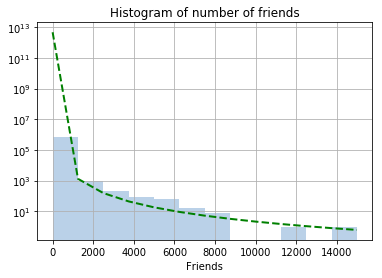

In [18]:
y, bins, patches = plt.hist(nonzero_friend_counts, 12, log=True, facecolor='#6699cc', alpha=0.45)

p = fit_to_powerlaw(bins[:-1], y)
print("p=",p)
plt.plot(bins, powerlaw(p, bins), 'g--', lw=2)

plt.xlabel('Friends')
plt.title('Histogram of number of friends')
plt.grid(True)
plt.show()

## Distribution of Reviews per user

In [19]:
user_review_count = {}
for review in reviews:
    user_id = review["user_id"]
    if user_id in user_review_count:
        user_review_count[user_id] += 1
    else:
        user_review_count[user_id] = 1
summary(user_review_count.values())

n    = 1183362
mean = 4.00291457728
sd   = 13.845164729
min  = 1
10%  = 1.0
25%  = 1.0
50%  = 1.0
75%  = 3.0
90%  = 7.0
max  = 3442


In [20]:
summary([user['review_count'] for user in users])


n    = 1183362
mean = 23.7268604197
sd   = 80.5064183211
min  = 0
10%  = 1.0
25%  = 2.0
50%  = 5.0
75%  = 16.0
90%  = 48.0
max  = 11656


In [22]:
sum([user['review_count'] for user in users])


28077465

In [23]:
sum(user_review_count.values())


4736897

In [24]:
len([user['user_id'] for user in users if user_review_count[user['user_id']] > user['review_count']])

1319

p= (1552109.0592496276, -1.2661929196125798)


/Users/kasknani/anaconda3/envs/Python27/lib/python2.7/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


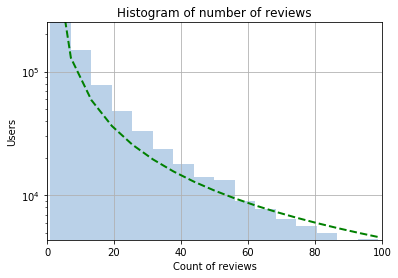

In [26]:
review_counts = [user['review_count'] for user in users if user['review_count']>0 and user['review_count']<100]
y, bins, patches = plt.hist(review_counts, 16, log=True, facecolor='#6699cc', alpha=0.45)

p = fit_to_powerlaw(bins[:-1], y)
print("p=",p)
plt.plot(bins, powerlaw(p, bins), 'g--', lw=2)

plt.xlabel('Count of reviews')
plt.ylabel('Users')
plt.title('Histogram of number of reviews')
plt.grid(True)
plt.axis([0, 100, 0, 250000])
plt.show()


In [27]:
len([user['review_count'] for user in users if user['review_count']>100])


57603

## Elite users

In [29]:
review_count_by_elite_years = []
for i in range(20):
    review_count_by_elite_years.append([])
for user in users:
    elite_years = len(user['elite'])
    review_count_by_elite_years[elite_years].append(user['review_count'])

In [30]:
elite = sum(len(review_count_by_elite_years[i]) for i in range(1,len(review_count_by_elite_years)))
print("Of %d users, %d or %0.1f%% have at some time qualified for elite status." % (len(users), elite, float(elite)/float(len(users))*100.0))

Of 1183362 users, 56121 or 4.7% have at some time qualified for elite status.


In [32]:
for elite_years in range(len(review_count_by_elite_years)):
    print("%2d %8.1f" % (elite_years, np.mean(review_count_by_elite_years[elite_years])))

 0     13.5
 1     99.8
 2    131.7
 3    195.9
 4    268.4
 5    333.7
 6    422.3
 7    503.8
 8    609.5
 9    752.3
10    904.7
11    927.5
12   1468.5
13   1953.6
14      nan
15      nan
16      nan
17      nan
18      nan
19      nan


/Users/kasknani/anaconda3/envs/Python27/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/kasknani/anaconda3/envs/Python27/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


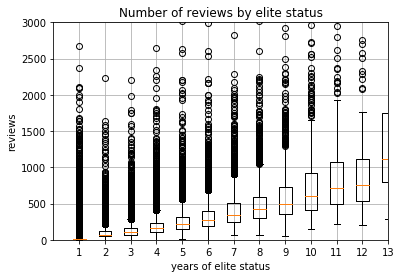

In [33]:
plt.boxplot(review_count_by_elite_years)
plt.axis([0,13,0,3000])
plt.ylabel('reviews')
plt.xlabel('years of elite status')
plt.title('Number of reviews by elite status')
plt.grid(True)
plt.show()

## Ratings


People seem to review things they like. The distribution of ratings is heavily skewed towards 4 and 5 stars.



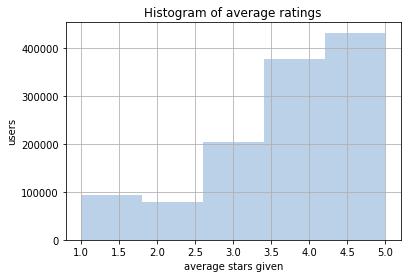

In [34]:
average_stars = [user['average_stars'] for user in users]
y, bins, patches = plt.hist(average_stars, 5, facecolor='#6699cc', alpha=0.45)

plt.xlabel('average stars given')
plt.ylabel('users')
plt.title('Histogram of average ratings')
plt.grid(True)
#plt.axis([0, 100, 0, 250000])
plt.show()